# Part 5: Keras LSTM

One of the last techniques that can be used is machine learning. Through the use of machine learning, the time series data can be modeled very accurately. In addition, the model has capability to predict better the previous techniques. But since there are hundreds of possible varieties, we will choose the LSTM architecture. The reference source for this advanced analysis can be found [here](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

### Loading and Preparing Data

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np  
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

#I tooke the appl stock data and moved it into a more convient file location
pathToData = "StockData\AppleStock.txt"

#Check if there is a valid file in directory
if(os.path.isfile(pathToData)):
    print("Path Found")
    data = pd.read_csv(pathToData, sep=",")
else:
    print("Path Not Found")

Path Found


In [4]:
datesData = data["Date"].tolist()
openPriceData = data["Open"].tolist() 
closePricedata = data["Close"].tolist()

print(len(datesData))
frontSlice = 8364 - 3650
endSlice = 8364
trimDatesData = datesData[frontSlice:endSlice]
trimOpenPriceData = openPriceData[frontSlice:endSlice]
trimClosePriceData = closePricedata[frontSlice:endSlice]

8364


In [5]:
#The Dates are in the in a string format. For a linear regression analysis,
#the dates need to placed into numeric values. We can correspond the dates to
#numbers from 0 - endDate
numericDatesData = []
for i in range(len(trimDatesData)):
    numericDatesData.append([i])
numericDatesData = np.array(numericDatesData)

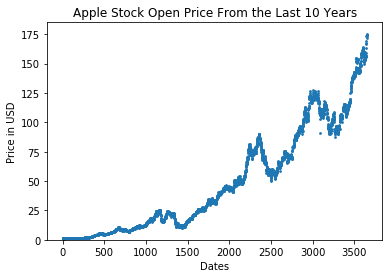

In [6]:
fig, ax = plt.subplots()
plt.scatter(numericDatesData, trimOpenPriceData, s = 3)
plt.title("Apple Stock Open Price From the Last 10 Years")
plt.xlabel("Dates")
plt.ylabel("Price in USD")
plt.ylim(0, max(trimOpenPriceData) + 10)
plt.show()

In [7]:
#We have to convert trimOpenPriceData to a 2d numpy array
h_list = []
for i in range(len(trimOpenPriceData)):
    h_list.append([trimOpenPriceData[i]])
trimOpenPriceData = np.array(h_list)

In [8]:
#Since LSTMs are sensitive to changes. Large numbers have to be normalized
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price_data = scaler.fit_transform(trimOpenPriceData)

In [9]:
# split into train and test sets with a  20 / 80 split
# Since sequence matters in an LSTM, shuffling the data is not advised
SPLIT = .8

train_size = int(len(scaled_price_data) * SPLIT)
test_size = len(scaled_price_data) - train_size

train_data = scaled_price_data[0:train_size,:]
test_data = scaled_price_data[train_size:len(scaled_price_data),:]

print("Training Data Points:", len(train_data))
print("Testing Data Points:", len(test_data))

Training Data Points: 2920
Testing Data Points: 730


In [10]:
# Convert an array of values into a dataset matrix. This is a 3D matrix that the
# LSTM requires to train on. 
def create_dataset(data, moving_window):
    """
    Params:
        data: data that is desired to be split
        moving_window: the window of data wanted to look back to predict
    Returns:
        dataX: a multi-dimensional array of data
        dataY: corresponding data for the X units
    """
    dataX, dataY = [], []
    for i in range(len(data)-moving_window-1):
        a = data[i:(i+moving_window), 0]
        dataX.append(a)
        dataY.append(data[i + moving_window, 0])
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    return dataX, dataY

In [11]:
#Creating the X,Y data sets
moving_window = 1 #let the model learn from the last 1 data points
x_train, y_train = create_dataset(train_data, moving_window)
x_test, y_test = create_dataset(test_data, moving_window)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2918, 1)
(2918,)
(728, 1)
(728,)


In [12]:
#LSTM wants data in the format [samples, time steps, features].
#Currently, the data is in the format [samples, features]

# reshape input to be [samples, time steps, features]
x_train = numpy.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = numpy.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2918, 1, 1)
(2918,)
(728, 1, 1)
(728,)


### Create and Train the LSTM Model 

In [13]:
# create and fit the LSTM network & do a quick epoch check to see a poor model
model = Sequential()
model.add(LSTM(4, input_shape=(1, moving_window)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 4s - loss: 0.0107


In [14]:
# make predictions
train_preds = model.predict(x_train)
test_preds = model.predict(x_test)
# invert predictions. This converts to normal data range
train_preds = scaler.inverse_transform(train_preds)
y_train = scaler.inverse_transform([y_train])
test_preds = scaler.inverse_transform(test_preds)
y_test = scaler.inverse_transform([y_test])

In [15]:
#join the two prediction into one cohesive unit
merge_preds = []
for data in train_preds:
    merge_preds.append(data)
for data in test_preds:
    merge_preds.append(data)

In [16]:
def get_rmse(preds, actual):
    N = len(preds)
    sum_diff = 0
    for i in range(N):
        diff = preds[i]-actual[i]
        sum_diff += diff ** 2
    sum_diff /= N
    RMSE = sum_diff ** .5
    return RMSE


In [17]:
rmse = get_rmse(merge_preds, trimOpenPriceData)

RMSE: [1.97944959]


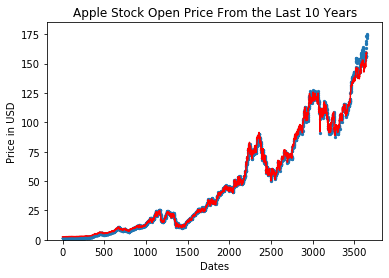

In [18]:
print("RMSE:", rmse)
fig, ax = plt.subplots()
plt.scatter(numericDatesData, trimOpenPriceData, s = 5)
plt.plot(merge_preds, color = "red" )
plt.title("Apple Stock Open Price From the Last 10 Years")
plt.xlabel("Dates")
plt.ylabel("Price in USD")
plt.ylim(0, max(trimOpenPriceData) + 10)
plt.show()

Like any other model, this LSTM can be hypertuned. Let us focus on the following metrics: epochs, moving_window, 

In [19]:
#Param tuning: moving_window
#Find the rough window of LSTMs for the network

def tune_model_moving_window(moving_window):
    batch_size = 1
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, moving_window)))
    model.add(Dense(1))

    return model 

In [20]:
x_train.shape

(2918, 1, 1)

In [ ]:
#Let us tune for the moving_window of somewhere with 25 layers
WINDOW_MAX = 25
comp_index = []
for window in range(WINDOW_MAX):
    moving_window = window + 1
    print("Window Size,", moving_window)
    x_train, y_train = create_dataset(train_data, moving_window)
    x_test, y_test = create_dataset(test_data, moving_window)
    x_train = numpy.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = numpy.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
    model = tune_model_moving_window(moving_window)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=30, batch_size=1, verbose=2)

    train_preds = scaler.inverse_transform(model.predict(x_train))
    test_preds = scaler.inverse_transform(model.predict(x_test))
    merge_preds = []
    
    for data in train_preds:
        merge_preds.append(data)
    for data in test_preds:
        merge_preds.append(data)
    
    rmse = get_rmse(merge_preds, trimOpenPriceData)
    comp_index.append([depth, rmse])



In [64]:
best_index = np.array([])
best_index = comp_index[0]
for index in comp_index:
    if best_index[1] > index[1]:
        best_index = index

print("Window Max: ", best_index[0])
print("RMSE: ", best_index[1])

With Depth:  1
RMSE:  [2.04873899]


Text(0, 0.5, 'RMSE')

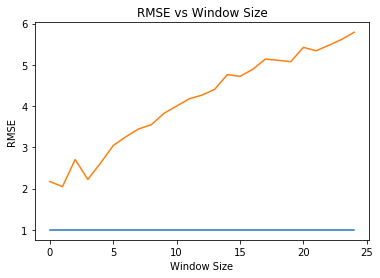

In [68]:
plt.plot(comp_index)
plt.title("RMSE vs Window Size")
plt.xlabel("Window Size")
plt.ylabel("RMSE")

In [ ]:
#Since we have derived that window size 1 is considered best. Let us tune the n
#number of epochs
#Let us tune for the moving_window of somewhere with 25 layers
EPOCH_MAX = 40
moving_window = 1
comp_index = []
for epoch in range(EPOCH_MAX):
    print("Epoch:", epoch)
    x_train, y_train = create_dataset(train_data, moving_window)
    x_test, y_test = create_dataset(test_data, moving_window)
    x_train = numpy.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = numpy.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
    model = tune_model_moving_window(moving_window)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=epoch, batch_size=1, verbose=2)

    train_preds = scaler.inverse_transform(model.predict(x_train))
    test_preds = scaler.inverse_transform(model.predict(x_test))
    merge_preds = []
    
    for data in train_preds:
        merge_preds.append(data)
    for data in test_preds:
        merge_preds.append(data)
    
    rmse = get_rmse(merge_preds, trimOpenPriceData)
    comp_index.append([epoch, rmse])



In [33]:
best_index = np.array([])
best_index = comp_index[0]
for index in comp_index:
    if best_index[1] > index[1]:
        best_index = index

print("Epoch: ", best_index[0])
print("RMSE: ", best_index[1])

Epoch:  2
RMSE:  [1.28521452]


Text(0, 0.5, 'RMSE')

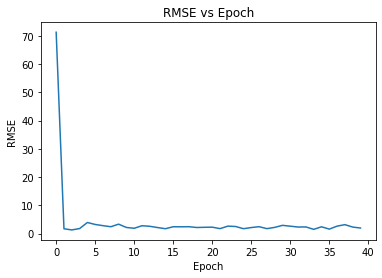

In [35]:
#epoch is the implied x axis
rmse_index = []
for data in comp_index:
    rmse_index.append(data[1])
plt.plot(rmse_index)
plt.title("RMSE vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")

There is an important case. A low epoch creates underfitting. A high epoch creates overfitting. The best epochs are seen at 1,9,20,33,36. Removing the lowest, one of the best epochs are 20,33, and 36. 

In [ ]:
#Since we have derived that window size 1 is considered best. 
#Since we have derived that 20,33,36 epochs are best, we can check their combiniation
#Let us tune for the moving_window of somewhere with 25 layers
EPOCH_MAX = [20,33,36]
WINDOW_MAX = [1,2,3,4,5]
comp_index = []
for epoch in EPOCH_MAX:
    for moving_window in WINDOW_MAX:
        print("Epoch:", epoch)
        print("Window:", moving_window)
        x_train, y_train = create_dataset(train_data, moving_window)
        x_test, y_test = create_dataset(test_data, moving_window)
        x_train = numpy.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
        x_test = numpy.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
        model = tune_model_moving_window(moving_window)
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(x_train, y_train, epochs=epoch, batch_size=1, verbose=2)

        train_preds = scaler.inverse_transform(model.predict(x_train))
        test_preds = scaler.inverse_transform(model.predict(x_test))
        merge_preds = []
    
        for data in train_preds:
            merge_preds.append(data)
        for data in test_preds:
            merge_preds.append(data)
    
        rmse = get_rmse(merge_preds, trimOpenPriceData)
        comp_index.append([moving_window, epoch, rmse])



In [22]:
best_index = np.array([])
best_index = comp_index[0]
for index in comp_index:
    if best_index[2] > index[2]:
        best_index = index

print("Epoch: ", best_index[1])
print("Window: ", best_index[0])
print("RMSE: ", best_index[2])

Epoch:  36
Window:  2
RMSE:  [1.64617627]


Thus, with these given parameters, we have a better tuned LSTM models. Since there are hundreds of permutations, especially with deep learning, hypertuning is a time extensive process that will take a bulk of time for modeling. 